🌍 アクセス中: 池上線 ...
  - 五反田駅 (品川区)
  - 大崎広小路駅 (品川区)
  - 戸越銀座駅 (品川区)
  - 荏原中延駅 (品川区)
  - 旗の台駅 (品川区)
  - 長原駅 (大田区)
  - 洗足池駅 (大田区)
  - 石川台駅 (大田区)
  - 雪が谷大塚駅 (大田区)
  - 御嶽山駅 (大田区)
  - 久が原駅 (大田区)
  - 千鳥町駅 (大田区)
  - 池上駅 (大田区)
  - 蓮沼駅 (大田区)
  - 蒲田駅 (大田区)
🌍 アクセス中: 東急多摩川線 ...
  - 多摩川駅 (大田区)
  - 沼部駅 (大田区)
  - 鵜の木駅 (大田区)
  - 下丸子駅 (大田区)
  - 武蔵新田駅 (大田区)
  - 矢口渡駅 (大田区)
  - 蒲田駅 (大田区)

📊 データベースからデータを読み込み中...
📈 グラフを作成しています...


/var/folders/7x/lsqh46k54ngbty2wwzntxt3r0000gn/T/ipykernel_28344/2042748323.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='line_name', ax=ax1, palette=line_colors)
/var/folders/7x/lsqh46k54ngbty2wwzntxt3r0000gn/T/ipykernel_28344/2042748323.py:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='line_name', y='transfer_count', ax=ax2, palette=line_colors, estimator="mean", errorbar=None)
/var/folders/7x/lsqh46k54ngbty2wwzntxt3r0000gn/T/ipykernel_28344/2042748323.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxp

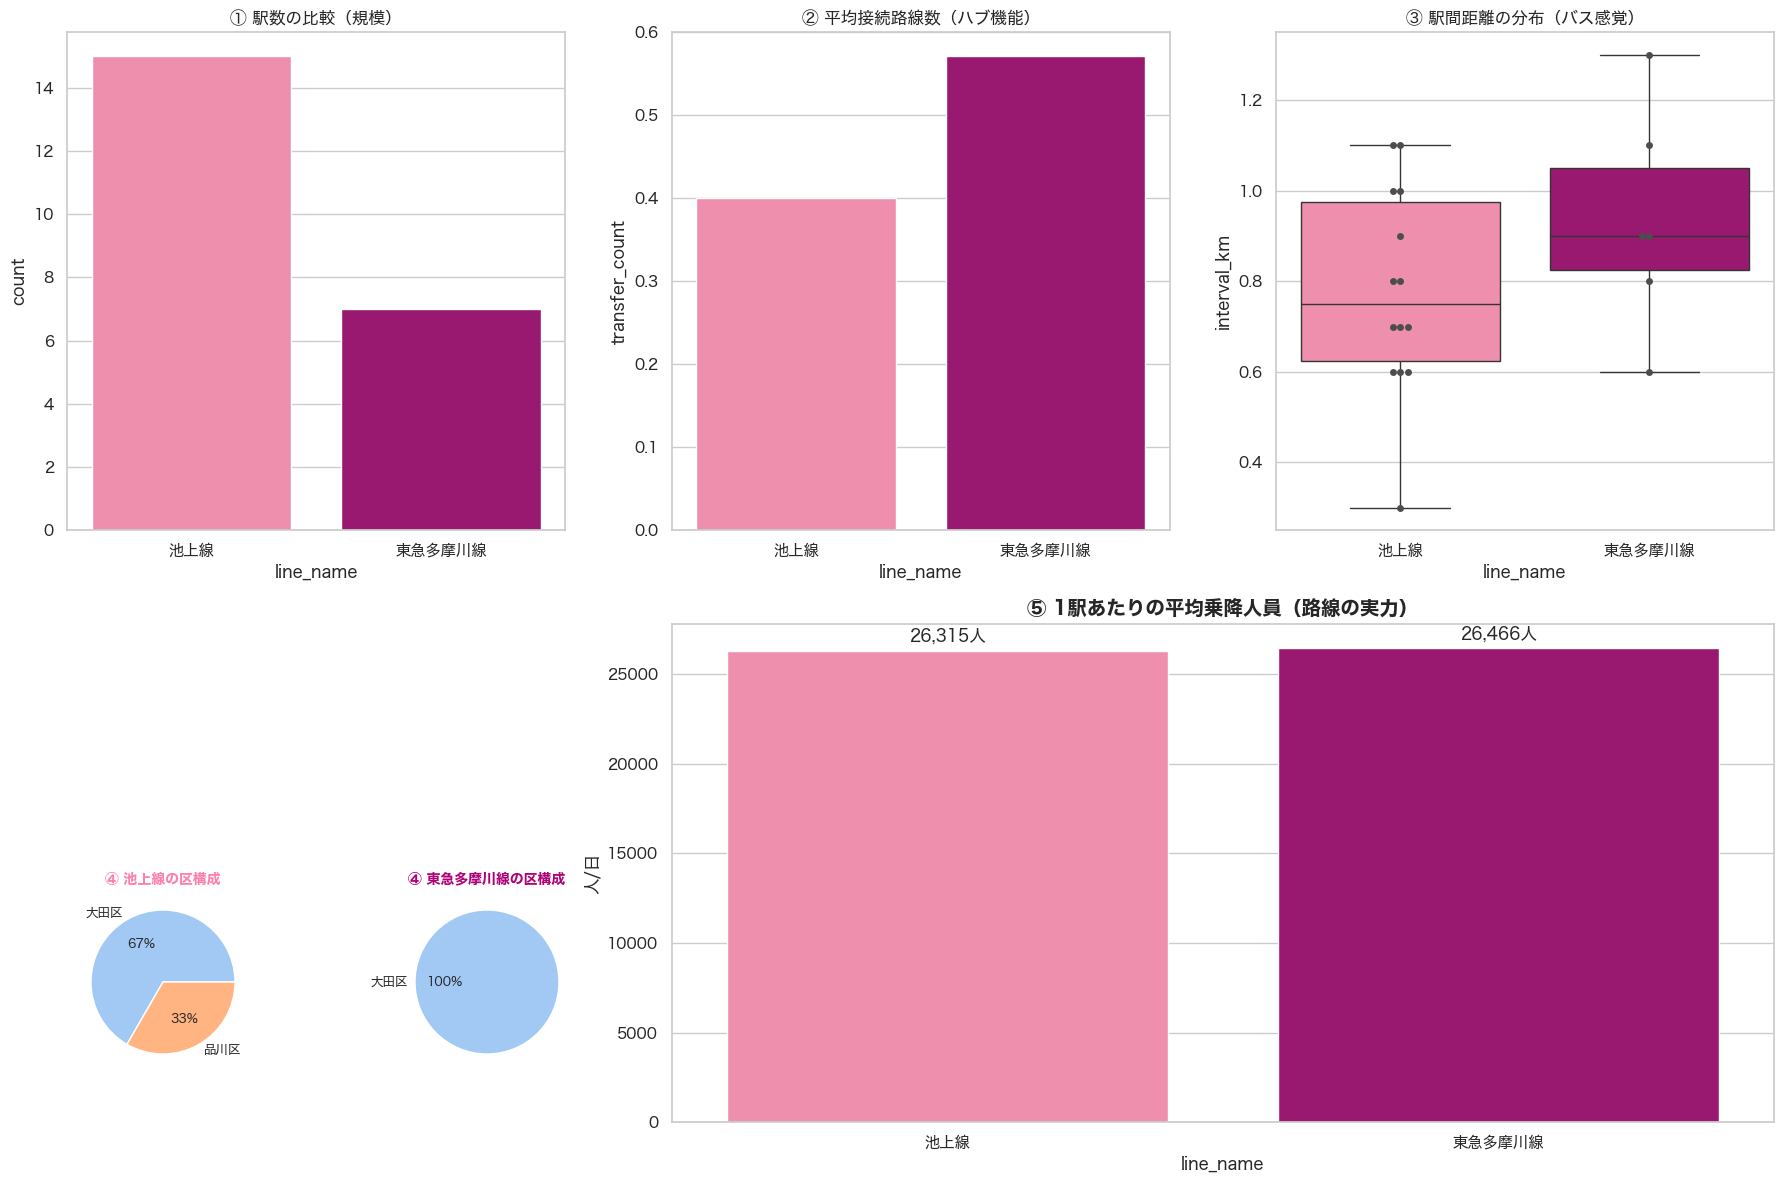

✨ 全工程完了！


In [2]:
import requests
from bs4 import BeautifulSoup
import sqlite3
import time
import datetime
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 設定クラス ---
class Config:
    DB_NAME = "tokyu_final_analysis.db"
    URLS = {
        "池上線": "https://ja.wikipedia.org/wiki/%E6%9D%B1%E6%80%A5%E6%B1%A0%E4%B8%8A%E7%B7%9A",
        "東急多摩川線": "https://ja.wikipedia.org/wiki/%E6%9D%B1%E6%80%A5%E5%A4%9A%E6%91%A9%E5%B7%9D%E7%B7%9A"
    }

# --- データベース管理クラス ---
class DatabaseManager:
    def __init__(self, db_name):
        self.db_name = db_name
        self.create_table()

    def create_table(self):
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()
        cursor.execute("DROP TABLE IF EXISTS stations")
        cursor.execute("""
            CREATE TABLE stations (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                line_name TEXT,
                station_name TEXT,
                interval_km REAL,
                transfers TEXT,
                ward TEXT,
                created_at TEXT
            )
        """)
        conn.commit()
        conn.close()

    def save_data(self, line_name, station_name, interval_km, transfers, ward):
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()
        now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        cursor.execute("""
            INSERT INTO stations (line_name, station_name, interval_km, transfers, ward, created_at)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (line_name, station_name, interval_km, transfers, ward, now))
        conn.commit()
        conn.close()

# --- スクレイピング実行クラス ---
class WikiScraper:
    def __init__(self, db_manager):
        self.db = db_manager
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        }
        self.last_ward = "不明"

    def fetch_and_save(self, line_name, url):
        print(f"🌍 アクセス中: {line_name} ...")
        self.last_ward = "不明"

        try:
            response = requests.get(url, headers=self.headers)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, "html.parser")

            tables = soup.find_all("table", class_="wikitable")
            target_table = None
            for table in tables:
                headers = [th.text.strip() for th in table.find_all("th")]
                if "駅間キロ" in str(headers) or "営業キロ" in str(headers):
                    target_table = table
                    break
            
            if not target_table:
                print("❌ テーブルが見つかりませんでした")
                return

            rows = target_table.find_all("tr")
            for row in rows:
                cols = row.find_all(["td", "th"])
                if len(cols) < 5: continue
                col_texts = [ele.text.strip() for ele in cols]
                
                try:
                    station_name = ""
                    interval_km = 0.0
                    transfers = "なし"
                    ward = self.last_ward

                    if len(col_texts) > 1:
                        raw_name = col_texts[1]
                        if "駅" not in raw_name and len(raw_name) < 2: raw_name = col_texts[2]
                        station_name = re.sub(r'\[.*?\]', '', raw_name)
                    
                    if not station_name or station_name == "駅名" or "キロ" in station_name: continue

                    if len(col_texts) > 2:
                        dist_match = re.search(r'([\d\.]+)', col_texts[2])
                        if dist_match: interval_km = float(dist_match.group(1))

                    if len(col_texts) > 4:
                        transfers = re.sub(r'\[.*?\]', '', col_texts[4])

                    if line_name == "東急多摩川線":
                        ward = "大田区"
                    else:
                        full_text = " ".join(col_texts)
                        ward_match = re.search(r'(千代田|中央|港|新宿|文京|台東|墨田|江東|品川|目黒|大田|世田谷|渋谷|中野|杉並|豊島|北|荒川|板橋|練馬|足立|葛飾|江戸川)区', full_text)
                        if ward_match:
                            ward = ward_match.group(0)
                            self.last_ward = ward
                        elif self.last_ward != "不明":
                            ward = self.last_ward

                    print(f"  - {station_name} ({ward})")
                    self.db.save_data(line_name, station_name, interval_km, transfers, ward)

                except Exception:
                    continue
            time.sleep(2)
        except Exception as e:
            print(f"❌ エラー: {e}")

# --- データ分析・可視化クラス ---
def analyze_and_visualize():
    print("\n📊 データベースからデータを読み込み中...")
    conn = sqlite3.connect(Config.DB_NAME)
    df = pd.read_sql_query("SELECT * FROM stations", conn)
    conn.close()
    
    if df.empty:
        print("❌ データが空です！")
        return

    df['transfer_count'] = df['transfers'].apply(lambda x: x.count("線") if x else 0)

    ridership_data = {
        "五反田": 95723, "大崎広小路": 7648, "戸越銀座": 19370, "荏原中延": 12777,
        "旗の台": 23000, "長原": 14880, "洗足池": 17037, "石川台": 14877, 
        "雪が谷大塚": 22365, "御嶽山": 23587, "久が原": 15640, "千鳥町": 15216, 
        "池上": 35181, "蓮沼": 8254, "蒲田": 69179,
        "多摩川": 3678, "沼部": 10289, "鵜の木": 19463, "下丸子": 31438,
        "武蔵新田": 25710, "矢口渡": 25506
    }
    
    def get_ridership(name):
        for key, value in ridership_data.items():
            if key in name: return value
        return 0
    
    df['ridership'] = df['station_name'].apply(get_ridership)

    print("📈 グラフを作成しています...")
    sns.set(style="whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Meiryo', 'Yu Gothic', 'Hiragino Sans', 'TakaoPGothic', 'Noto Sans CJK JP']

    line_colors = {
        "池上線": "#FE7FA7",
        "東急多摩川線": "#AE0378"
    }

    fig = plt.figure(figsize=(18, 12))
    
    # 1. 駅数比較
    ax1 = plt.subplot2grid((2, 3), (0, 0))
    sns.countplot(data=df, x='line_name', ax=ax1, palette=line_colors)
    ax1.set_title("① 駅数の比較（規模）", fontsize=12)

    # 2. 接続数比較
    ax2 = plt.subplot2grid((2, 3), (0, 1))
    sns.barplot(data=df, x='line_name', y='transfer_count', ax=ax2, palette=line_colors, estimator="mean", errorbar=None)
    ax2.set_title("② 平均接続路線数（ハブ機能）", fontsize=12)

    # 3. 駅間距離分布
    ax3 = plt.subplot2grid((2, 3), (0, 2))
    sns.boxplot(data=df[df['interval_km']>0], x='line_name', y='interval_km', ax=ax3, palette=line_colors)
    sns.swarmplot(data=df[df['interval_km']>0], x='line_name', y='interval_km', ax=ax3, color=".3")
    ax3.set_title("③ 駅間距離の分布（バス感覚）", fontsize=12)

    # 4. 所在地構成（円グラフ）
    ax4 = plt.subplot2grid((2, 3), (1, 0))
    ax4.axis('off')
    lines = df['line_name'].unique()
    pie_positions = [[0.02, 0.1, 0.15, 0.15], [0.20, 0.1, 0.15, 0.15]]

    for i, line in enumerate(lines):
        if i >= len(pie_positions): break
        target_ax = fig.add_axes(pie_positions[i])
        subset = df[df['line_name'] == line]
        ward_counts = subset['ward'].value_counts()
        if not ward_counts.empty:
            target_ax.pie(ward_counts, labels=ward_counts.index, autopct='%1.0f%%', 
                          colors=sns.color_palette("pastel"), textprops={'fontsize': 9})
            target_ax.set_title(f"④ {line}の区構成", fontsize=10, color=line_colors.get(line, "black"), fontweight='bold')

    # 5. 平均乗降人員比較
    ax5 = plt.subplot2grid((2, 3), (1, 1), colspan=2)
    sns.barplot(data=df, x='line_name', y='ridership', ax=ax5, palette=line_colors, estimator="mean", errorbar=None)
    ax5.set_title("⑤ 1駅あたりの平均乗降人員（路線の実力）", fontsize=14, fontweight='bold')
    ax5.set_ylabel("人/日")
    
    for p in ax5.patches:
        height = p.get_height()
        if height > 0:
            ax5.annotate(f'{int(height):,}人', (p.get_x() + p.get_width() / 2., height), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    plt.tight_layout()
    plt.show()
    print("✨ 全工程完了！")

if __name__ == "__main__":
    db = DatabaseManager(Config.DB_NAME)
    scraper = WikiScraper(db)
    for line, url in Config.URLS.items():
        scraper.fetch_and_save(line, url)
    analyze_and_visualize()